# Rede Neural - Predict



## Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn import preprocessing
from sklearn.preprocessing  import  StandardScaler 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras import backend as K
import copy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## Carregando a base de dados

In [0]:
cali = pd.read_csv('housing.csv')

In [27]:
keep = ['housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_income',
        'median_house_value', 'ocean_proximity']

df = cali[keep].copy()
df

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...
20635,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


## Limpando a base

In [0]:
#Removendo outliers
df = df.loc[df.median_house_value < 500000]

In [8]:
#Removendo missing values
df = df.dropna()
df.shape

(19448, 8)

## Preparando df_X

In [0]:
df_X = pd.concat([df.select_dtypes('int'), df.select_dtypes('float')], axis = 1, ignore_index = False)

In [0]:
#Log no preço
df_X['median_house_value_log'] = np.log10(df.median_house_value)

## Visualizando as distribuições do target

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'median_house_value_log')

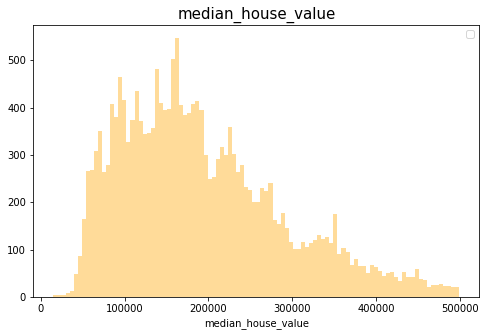

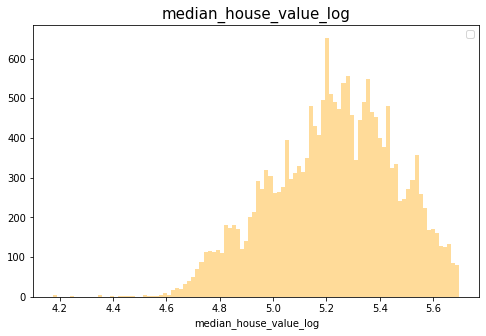

In [15]:
plt.figure(figsize = (8,5))
sns.distplot(df.median_house_value, bins = 100,
             kde = False, color ='orange') 
plt.legend()
plt.title("median_house_value", fontsize=15)

plt.figure(figsize = (8,5))
sns.distplot(df_X.median_house_value_log, bins = 100,
             kde = False, color ='orange') 
plt.legend()
plt.title("median_house_value_log", fontsize=15)

## Padronizando variáveis numéricas e separadando as categóricas

In [0]:
scaler = StandardScaler()
scaler_y = StandardScaler()

#padronizando variáveis numéricas
numerical_cols = (df.select_dtypes('int') & 
                  df.select_dtypes('float')).columns
target_col = ['median_house_value_log']

numerical_data = df_X[numerical_cols].copy()
target_data = df_X[target_col].copy()

transformed_x = scaler.fit_transform(numerical_data)
transformed_y = scaler_y.fit_transform(target_data)
df_X.loc[:, numerical_cols] = transformed_x
df_X.loc[:, target_col] = transformed_y

#variáveis categóricas
categorical_data = df.select_dtypes('object').copy()
categorical_data = categorical_data.apply(lambda x: x.astype(str).str.lower())

In [22]:
dummies = pd.get_dummies(categorical_data)
dummies

,ocean_proximity_<1h ocean,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near bay,ocean_proximity_near ocean
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0
...,...,...,...,...,...
20635,0,1,0,0,0
20636,0,1,0,0,0
20637,0,1,0,0,0
20638,0,1,0,0,0


In [23]:
df_X = df_X.join(dummies)

df_X

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,median_house_value_log,ocean_proximity_<1h ocean,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near bay,ocean_proximity_near ocean
0,1.010020,-0.796494,-0.971846,-0.977333,-0.978544,2.961839,2.683841,1.861403,0,0,0,1,0
1,-0.588709,2.048533,1.340349,0.838702,1.661517,2.946675,1.714668,1.423363,0,0,0,1,0
2,1.889321,-0.527957,-0.827481,-0.825341,-0.845497,2.281519,1.648752,1.389509,0,0,0,1,0
3,1.889321,-0.616250,-0.720983,-0.771183,-0.735930,1.253011,1.537518,1.330961,0,0,0,1,0
4,1.889321,-0.454762,-0.614485,-0.765069,-0.631579,0.108164,1.546788,1.335911,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-0.268963,-0.437378,-0.392022,-0.520485,-0.446358,-1.348235,-1.173283,-1.440655,0,1,0,0,0
20636,-0.828519,-0.880212,-0.922147,-0.947633,-1.009849,-0.713342,-1.183583,-1.464873,0,1,0,0,0
20637,-0.908455,-0.167926,-0.129326,-0.378976,-0.177656,-1.259229,-1.027032,-1.126701,0,1,0,0,0
20638,-0.828519,-0.348170,-0.309190,-0.611330,-0.396791,-1.152702,-1.105307,-1.288191,0,1,0,0,0


## Definindo y e X

In [0]:
y_var = 'median_house_value_log'

x_var = df_X.columns.tolist()
x_var.remove(y_var)

In [0]:
y = df_X[y_var].values
X = df_X[x_var].values

## Treino

In [0]:
RMSprop = optimizers.RMSprop(lr=0.001, rho=0.9)
callbacks = [EarlyStopping(monitor='val_loss', patience=100, verbose=1, restore_best_weights=True)]

def coeff_determination(y_true, y_pred):
  SS_res = ((y_true-y_pred)**2).sum()
  SS_tot = ((y_true-y_true.mean())**2).sum()
  return (1 - SS_res/SS_tot)

n_neurons = [1,2,3,4,5]
n_iterations = 5

result = [0,]
choose_model = []
for n in (n_neurons):
  model = Sequential()
  model.add(Dense(n, activation='tanh', input_shape=(X.shape[1],)))
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer=RMSprop,loss='mse',metrics=['mae', 'mape'])
  r2_history = []
  for k in range(n_iterations):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.8)
    hist = model.fit(X_train, y_train,batch_size=len(X), epochs=500, callbacks=callbacks, validation_data=(X_val, y_val))
    y_pred = model.predict(X_val).flatten()
    r2_history.append(coeff_determination(y_val,y_pred))
    best_model = [0,0,0]
    if r2_history[-1] > best_model[0]:
      best_model[0] = r2_history[-1]
      best_model[1] = copy.deepcopy(model)
      best_model[2] = n
  result.append(r2_history)
  choose_model.append(best_model)

Streaming output truncated to the last 5000 lines.
3889/3889 [==============================] - 0s 4us/step - loss: 1.5756 - mae: 1.0163 - mape: 15076.6709 - val_loss: 1.5372 - val_mae: 1.0026 - val_mape: 39740.5273
Epoch 4/500
3889/3889 [==============================] - 0s 3us/step - loss: 1.5299 - mae: 1.0007 - mape: 14614.8945 - val_loss: 1.4971 - val_mae: 0.9887 - val_mape: 39118.2109
Epoch 5/500
3889/3889 [==============================] - 0s 3us/step - loss: 1.4903 - mae: 0.9871 - mape: 14218.5195 - val_loss: 1.4611 - val_mae: 0.9761 - val_mape: 38552.3828
Epoch 6/500
3889/3889 [==============================] - 0s 3us/step - loss: 1.4547 - mae: 0.9747 - mape: 13863.0791 - val_loss: 1.4281 - val_mae: 0.9645 - val_mape: 38027.6719
Epoch 7/500
3889/3889 [==============================] - 0s 3us/step - loss: 1.4220 - mae: 0.9632 - mape: 13536.5615 - val_loss: 1.3974 - val_mae: 0.9535 - val_mape: 37534.4688
Epoch 8/500
3889/3889 [==============================] - 0s 3us/step - loss:

## Resultados

In [0]:
df_result = pd.DataFrame(result, columns=['r2'])

df_result = df_result.r2.apply(pd.Series)
df_result = df_result.T

df_result

,0,1,2,3,4,5
0,0.0,0.043957,0.767827,0.972352,0.968561,0.986086
1,NaN,0.616800,0.978522,0.995976,0.992564,0.995419
2,NaN,0.893932,0.997605,0.997343,0.997387,0.997207
3,NaN,0.960693,0.997993,0.998194,0.998025,0.997220
4,NaN,0.975487,0.998060,0.998516,0.998465,0.998875


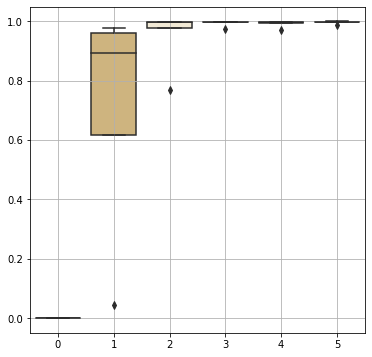

In [0]:
fig = plt.figure(figsize=(6,6))
ax = sns.boxplot(data=df_result, orient="v", palette="BrBG")
ax.set_xticklabels(ax.get_xticklabels(), rotation=360);
ax.grid()

In [0]:
df_model = pd.DataFrame(choose_model, columns=['r2','model','number_of_neurons'])
df_model

,r2,model,number_of_neurons
0,0.975487,<keras.engine.sequential.Sequential object at ...,1
1,0.998060,<keras.engine.sequential.Sequential object at ...,2
2,0.998516,<keras.engine.sequential.Sequential object at ...,3
3,0.998465,<keras.engine.sequential.Sequential object at ...,4
4,0.998875,<keras.engine.sequential.Sequential object at ...,5


In [0]:
df_model_3 = df_model.loc[df_model.number_of_neurons == 3]

model_3 = df_model_3.iloc[0,1]

In [0]:
model_3.save('model_3.h5')

In [0]:
pred = model_3.predict(X)
pred_log = scaler_y.inverse_transform(pred)
pred_log

array([[5.6574883],
       [5.5541053],
       [5.553311 ],
       ...,
       [4.9624124],
       [4.922177 ],
       [4.945135 ]], dtype=float32)

In [0]:
df_comp = pd.DataFrame()

df_comp['price_real'] = df['median_house_value'].copy()
df_comp['price_pred'] = 10**(pred_log)

df_comp

,price_real,price_pred
0,452600.0,454452.343750
1,358500.0,358183.250000
2,352100.0,357528.656250
3,341300.0,345821.687500
4,342200.0,345852.437500
...,...,...
20635,78100.0,76938.406250
20636,77100.0,75549.406250
20637,92300.0,91709.085938
20638,84700.0,83594.335938
